<a href="https://colab.research.google.com/github/c-mmonteiro/t2-aprendizado/blob/main/Trabalho3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 3: Classificação de Animais
Disciplina: Aprendizado de Máquina

Autor: Carlos Monteiro

# 1. Carregamento e separação dos dados

## 1.1 Baixe as imagens do Kaggle (ou conecte ao dataset caso esteja utilizando no Kaggle)

In [40]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:20<00:00, 29.4MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [41]:
import subprocess

subprocess.run(["cp", "-r", path + "/raw-img", "."])

CompletedProcess(args=['cp', '-r', '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img', '.'], returncode=0)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split

2025-10-24 02:47:43.390108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-24 02:47:43.390142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-24 02:47:43.391361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-24 02:47:43.397811: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print(f"Device: {device}")
        tf.config.experimental.set_memory_growth(device, True)

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [4]:
!nvidia-smi

Fri Oct 24 02:47:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off |   00000000:17:00.0 Off |                  N/A |
|  0%   45C    P5             13W /  250W |       9MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
%%time
if os.path.exists('data.csv'):
    df = pd.read_csv('data.csv', index_col=0)
else:
    # Create dataframe with paths and labels of all images
    df = pd.DataFrame()
    for dirname, _, filenames in os.walk("./raw-img"):
        paths = [dirname + '/' + filename for filename in filenames]
        folder_name = os.path.split(dirname)[-1]
        df = pd.concat([df, pd.DataFrame({'path': paths, 'target': folder_name})], ignore_index=True)
    df = df.sort_values('path').reset_index(drop=True)

    # Translate labels to English
    translation = {"cane": "dog",
                   "cavallo": "horse",
                   "elefante": "elephant",
                   "farfalla": "butterfly",
                   "gallina": "chicken",
                   "gatto": "cat",
                   "mucca": "cow",
                   "pecora": "sheep",
                   "ragno": "spider",
                   "scoiattolo": "squirrel"}
    df.loc[:, 'target'] = df['target'].map(translation)

    # Add height and width information
    df.loc[:, ['height', 'width']] = df['path'].apply(lambda fn: Image.open(fn).size[::-1]).to_list()
    df.loc[:, ['min_dim', 'max_dim']] = df.loc[:, ['height', 'width']].apply(lambda row: sorted(row), axis=1).to_list()

    # Add filename extension information
    df.loc[:, 'extension'] = df['path'].apply(lambda s: s.split('.')[-1].lower()).to_list()

    df.to_csv('data.csv')
df

CPU times: user 41.2 ms, sys: 14.4 ms, total: 55.6 ms
Wall time: 53.6 ms


path    target  height  \
0         ./raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg       dog     225   
1      ./raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS....       dog     214   
2      ./raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....       dog     225   
3      ./raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....       dog     225   
4      ./raw-img/cane/OIP---_cJbI6Ei26w5bW1urHewHaCf....       dog     101   
...                                                  ...       ...     ...   
26174  ./raw-img/scoiattolo/OIP-zpD7SDCbIqwjYm2A06Oyb...  squirrel     300   
26175  ./raw-img/scoiattolo/OIP-zpZ5t_rN3DA6xByG0o05W...  squirrel     201   
26176  ./raw-img/scoiattolo/OIP-zwWLqRd95U-BjagmhkAgo...  squirrel     209   
26177  ./raw-img/scoiattolo/OIP-zyCc-DDxjCSB5m9DR3uNK...  squirrel     200   
26178  ./raw-img/scoiattolo/OIP-zzy5kEbHuGBWXZ3c-D85a...  squirrel     200   

       width  min_dim  max_dim extension  
0        300      225      300      jpeg  
1        300      214      300      jpeg  
2        300      225      300      jpeg  
3        300      225      300      jpeg  
4        300      101      300      jpeg  
...      ...      ...      ...       ...  
26174    277      277      300      jpeg  
26175    300      201      300      jpeg  
26176    300      209      300      jpeg  
26177    300      200      300      jpeg  
26178    300      200      300      jpeg  

[26179 rows x 7 columns]

## 1.2 Filtre e reduza o dataset para o tamanho desejado

Selecione somente imagens com a extensão .jpg/.jpeg

Selecione somente imagens com largura e altura superior ou igual a 225 e com largura ou altura igual a 300

Selecione somente 150 imagens por classe


In [6]:
df = df.loc[(df['extension'] == 'jpg') | (df['extension'] == 'jpeg')]
df = df.loc[(df['height'] >= 225) & (df['width'] >= 225)]
df = df.loc[(df['height'] == 300) | (df['width'] == 300)]
df = df.groupby('target').head(150)
df = df.reset_index(drop=True)
df

path    target  height  \
0        ./raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg       dog     225   
1     ./raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....       dog     225   
2     ./raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....       dog     225   
3     ./raw-img/cane/OIP--1QXriWyOTJg-9fEwbznmgHaI4....       dog     300   
4     ./raw-img/cane/OIP--6UY_QQC69uZF4CrwEcfUQHaHa....       dog     300   
...                                                 ...       ...     ...   
1495  ./raw-img/scoiattolo/OIP-DcQf4YaC723GXS-XXV9EF...  squirrel     225   
1496  ./raw-img/scoiattolo/OIP-DlVY-0x9uqexVnZY_1TXx...  squirrel     290   
1497  ./raw-img/scoiattolo/OIP-Dnzd5Zi2pMoZ5xrFNVPeK...  squirrel     300   
1498  ./raw-img/scoiattolo/OIP-DsptawZTCAgdcDrT5SEeq...  squirrel     225   
1499  ./raw-img/scoiattolo/OIP-DuPRPtoVdmJ79aMmVvJk5...  squirrel     259   

      width  min_dim  max_dim extension  
0       300      225      300      jpeg  
1       300      225      300      jpeg  
2       300      225      300      jpeg  
3       251      251      300      jpeg  
4       300      300      300      jpeg  
...     ...      ...      ...       ...  
1495    300      225      300      jpeg  
1496    300      290      300      jpeg  
1497    300      300      300      jpeg  
1498    300      225      300      jpeg  
1499    300      259      300      jpeg  

[1500 rows x 7 columns]

In [7]:
df['height'].max()

300

In [8]:
df['width'].max()

300

In [9]:
df['target'].value_counts()

dog          150
horse        150
elephant     150
butterfly    150
chicken      150
cat          150
cow          150
sheep        150
spider       150
squirrel     150
Name: target, dtype: int64

## 1.3 Observe alguns exemplos de imagens de cada classe

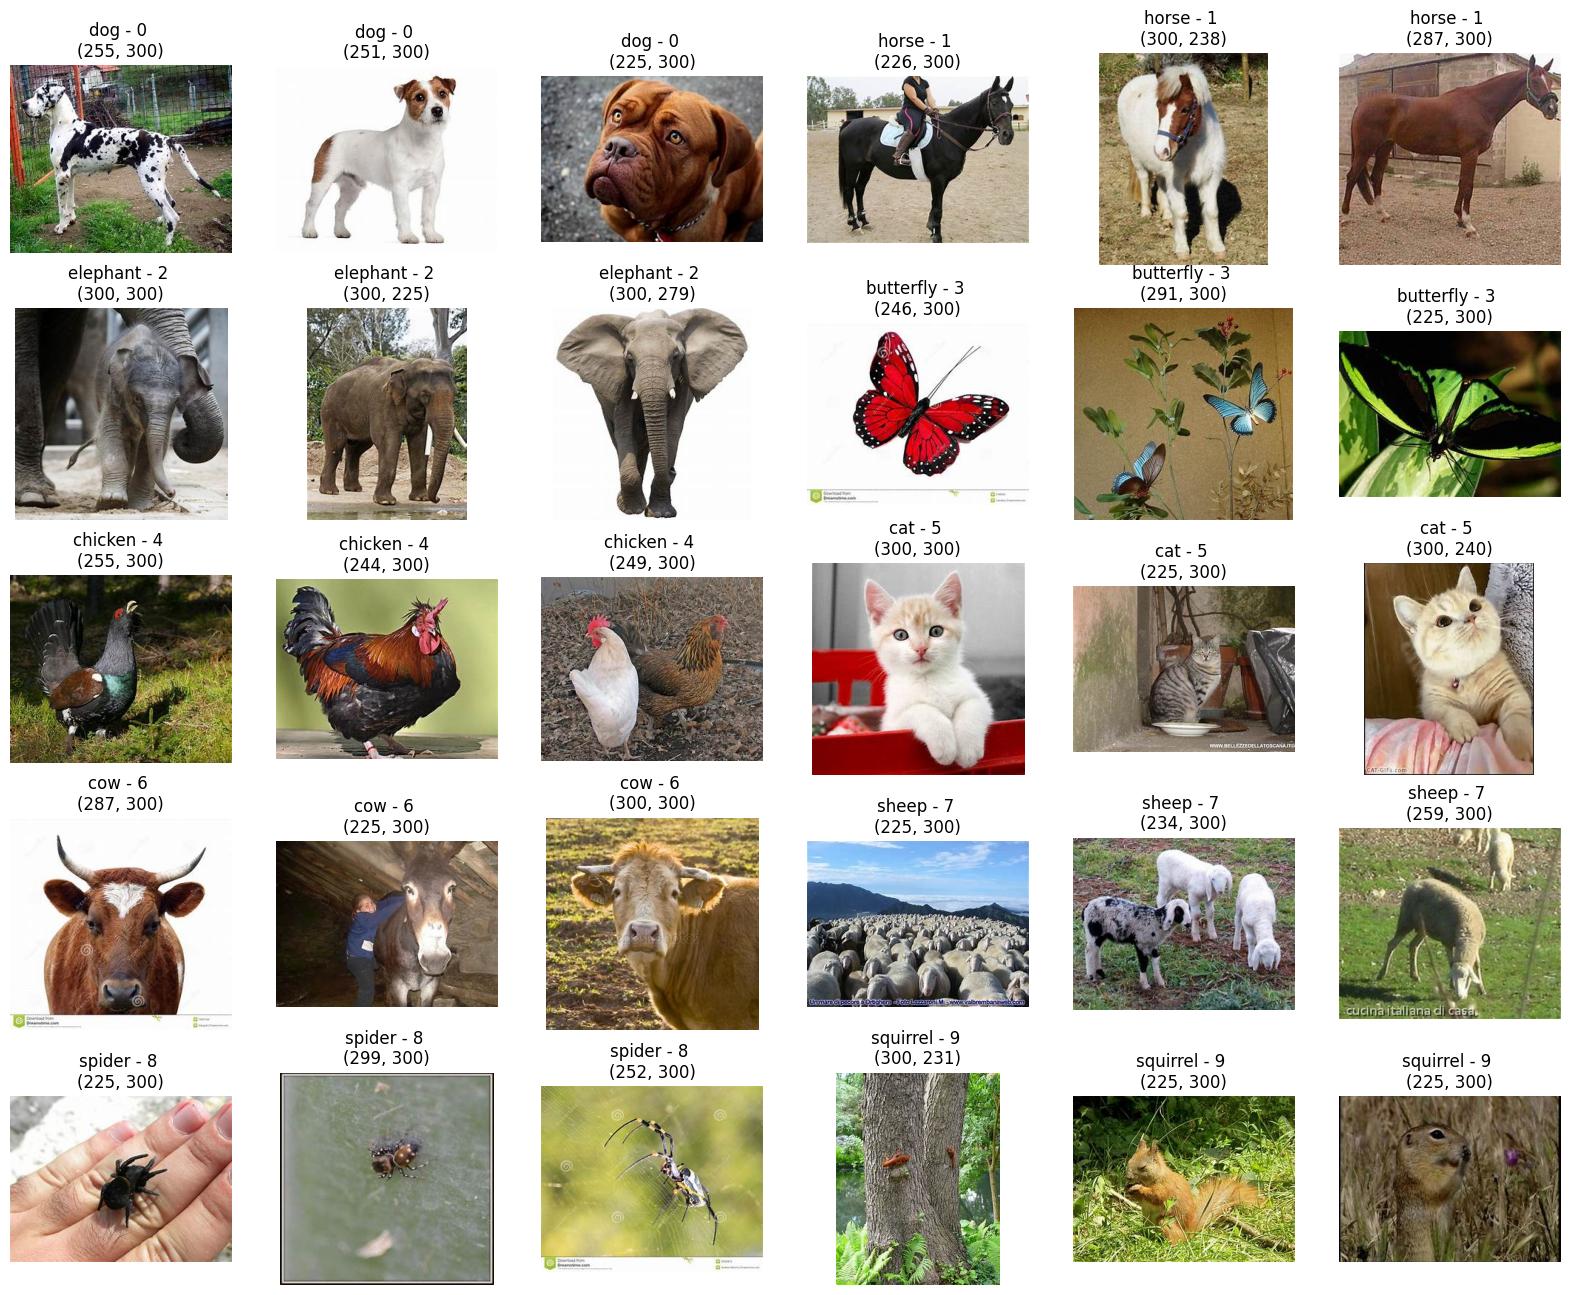

In [10]:
# Show a few examples
plt.figure(figsize=(20, 16))
for i, label in enumerate(df['target'].unique()):
  subset = df['path'][df['target'] == label].sample(3, random_state=0)
  for j in range(3):
    plt.subplot(5, 6, 3*i+j+1)
    img = plt.imread(subset.iloc[j])
    plt.imshow(img)
    plt.title(f'{label} - {i} \n{img.shape[:2]}')
    plt.axis('off')

## 1.4 Separe os conjuntos de dados entre treino, treino reduzido, validação e teste conforme especificado na introdução

In [11]:
# Train/val/test split (with the same number of images per class)

images_per_class = 25
random_state = 0
n_classes = len(df['target'].unique())

df_train_val,   df_test = train_test_split(df,            test_size=images_per_class*n_classes, stratify=df['target'],           random_state=random_state)
df_train,       df_val  = train_test_split(df_train_val,  test_size=images_per_class*n_classes, stratify=df_train_val['target'], random_state=random_state)
df_train_small, _       = train_test_split(df_train,     train_size=images_per_class*n_classes, stratify=df_train['target'],     random_state=random_state)

print(f'Train set (full)  : {len(df_train):4d} images ({int(len(df_train)/n_classes):3d} per class)')
print(f'Train set (small) : {len(df_train_small):4d} images ({int(len(df_train_small)/n_classes):3d} per class)')
print(f'Validation set    : {len(df_val):4d} images ({int(len(df_val)/n_classes):3d} per class)')
print(f'Test set          : {len(df_test):4d} images ({int(len(df_test)/n_classes):3d} per class)')

Train set (full)  : 1000 images (100 per class)
Train set (small) :  250 images ( 25 per class)
Validation set    :  250 images ( 25 per class)
Test set          :  250 images ( 25 per class)


In [12]:
def create_dataset(dataframe, img_size, batch_size, seed=None):
    paths = dataframe['path']
    labels = dataframe['target'].map(sorted(dataframe['target'].unique()).index) # ordinal encoder
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.shuffle(len(ds), seed=seed)

    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        return image, label
    
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# 2. Desenvolvimento principal


In [13]:
def plots(history, xlim=None, ylim=None):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  metrics = [m for m in history.keys() if not (m == 'loss' or m.startswith('val_') or m.startswith('Unnamed'))]
  if len(metrics) == 0: return
  plt.subplot(1, 2, 2)
  plt.plot(history[metrics[0]], '.-', label='Train ' + metrics[0])
  plt.xlabel('Epochs');
  if 'val_' + metrics[0] in history.keys():
    v = list(history['val_' + metrics[0]])
    plt.plot(v, '.-', label='Val ' + metrics[0])
    plt.title(f"Val {metrics[0]}: {max(v):.1%} (max) | {v[-1]:.1%} (last)");
  plt.legend();
  plt.xlim(xlim);
  plt.ylim(ylim);
  plt.grid();

In [14]:
from keras.applications.xception import Xception, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

def make_model(df_train, df_val, batch_size, data_augmentation_layer=None, image_net = True, img_size=(80, 80), epochs=25):

    ds_train = create_dataset(df_train, img_size, batch_size)
    ds_val = create_dataset(df_val, img_size, batch_size)

    input_shape = img_size + (3,)

    if image_net:
        base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
    else:
        base_model = Xception(include_top=False, weights=None, input_shape=input_shape, pooling='avg')

    base_model.trainable = True
    for layer in base_model.layers:
        if isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = False

    if data_augmentation_layer is None:
        data_augmentation_layer = keras.layers.Lambda(lambda x: x)

    keras.utils.set_random_seed(0)
    model = keras.Sequential(
        [
            keras.layers.Input(shape=input_shape),
            data_augmentation_layer,
            keras.layers.Lambda(preprocess_input),
            base_model,
            keras.layers.Dense(10, activation='softmax'),
        ]
    )

    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.00001))

    model.summary()

    callbacks = [EarlyStopping(patience=20), ReduceLROnPlateau(factor=0.2, patience=15, verbose=1)]

    history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks, batch_size=batch_size)

    return [history, model]

## 2.1 Modelo baseline

a) Treine um modelo baseline

- Escolha uma arquitetura do Keras Applications como backbone, importe o modelo com os pesos da ImageNet e realize as adaptações necessárias (adição de camada de saída, preprocess_function, etc)

- Escolha alguns parâmetros iniciais como tamanho da imagem (80x80, 100x100, …), um batch_size e taxa de aprendizado adequados, treine o por cerca de 25 épocas e observe o resultado encontrado


2025-10-24 02:28:06.916502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10305 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1
2025-10-24 02:28:06.917425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10295 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 80, 80, 3)         0         
                                                                 
 lambda_1 (Lambda)           (None, 80, 80, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25


2025-10-24 02:28:13.162366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2025-10-24 02:28:13.875999: I external/local_xla/xla/service/service.cc:168] XLA service 0x74a7a0f0d930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-24 02:28:13.876033: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-10-24 02:28:13.876040: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-10-24 02:28:13.882898: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761272893.981953  429922 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 17s 2s/step - loss: 2.6403 - accuracy: 0.0960 - val_loss: 2.4757 - val_accuracy: 0.1400 - lr: 1.0000e-05
Epoch 2/25
4/4 [==============================] - 1s 355ms/step - loss: 2.1962 - accuracy: 0.2240 - val_loss: 2.3078 - val_accuracy: 0.1800 - lr: 1.0000e-05
Epoch 3/25
4/4 [==============================] - 0s 121ms/step - loss: 1.9178 - accuracy: 0.3280 - val_loss: 2.1876 - val_accuracy: 0.2320 - lr: 1.0000e-05
Epoch 4/25
4/4 [==============================] - 0s 124ms/step - loss: 1.6948 - accuracy: 0.4640 - val_loss: 2.0908 - val_accuracy: 0.2720 - lr: 1.0000e-05
Epoch 5/25
4/4 [==============================] - 0s 119ms/step - loss: 1.4990 - accuracy: 0.5960 - val_loss: 2.0065 - val_accuracy: 0.2960 - lr: 1.0000e-05
Epoch 6/25
4/4 [==============================] - 0s 121ms/step - loss: 1.3168 - accuracy: 0.6520 - val_loss: 1.9314 - val_accuracy: 0.3320 - lr: 1.0000e-05
Epoch 7/25
4/4 [==============================] - 0s 122ms/step - loss:

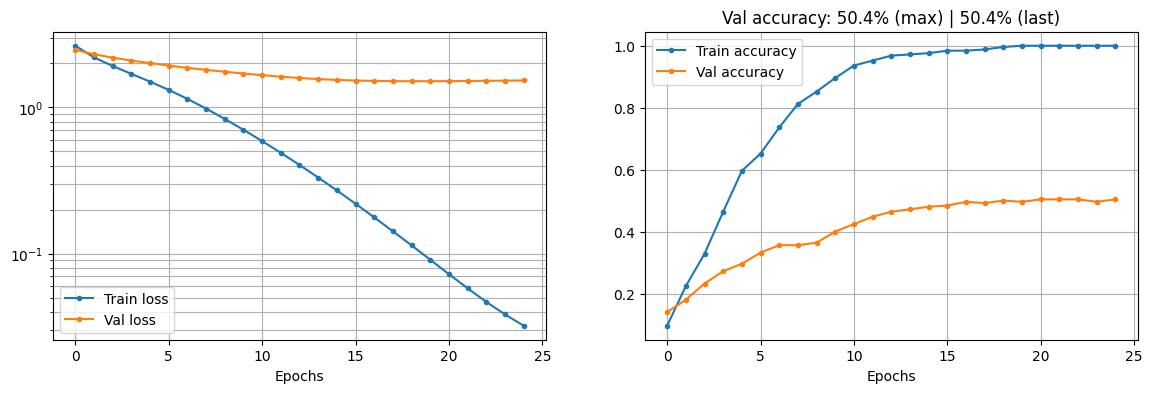

In [13]:
[h, m] = make_model(df_train_small, df_val, 
                    batch_size=64, data_augmentation_layer=None, 
                    image_net=True, img_size=(80, 80), epochs=25)

plots(h)

b) Otimize o batch size e a taxa de aprendizado

In [14]:
history = []
val_acc = []
batch_size_list = [25, 50, 100, 250]
for batch_size in batch_size_list:
  [h, m] = make_model(df_train_small, df_val, 
                    batch_size=batch_size, data_augmentation_layer=None, 
                    image_net=True, img_size=(80, 80), epochs=25)
  
  history.append(h)
  val_acc.append(h.history['val_accuracy'][-1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 80, 80, 3)         0         
                                                                 
 lambda_3 (Lambda)           (None, 80, 80, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25
10/10 [==============================] - 11s 133ms/step - loss: 2.5517 - accuracy: 0.1080 - val_loss: 2.3201 - val_accuracy: 0.1

In [15]:
print(f'Acurácia de Validação por Tamanho de Batch:')
print(f'Tamanho do Batch | Acurácia ')
print(f'-----------------|----------')
for i, acc in enumerate(val_acc):
  print(f'{str(batch_size_list[i]).center(17)}| {acc:.4f} ')

Acurácia de Validação por Tamanho de Batch:
Tamanho do Batch | Acurácia 
-----------------|----------
        25       | 0.5560 
        50       | 0.5160 
       100       | 0.5080 
       250       | 0.3800 


## 2.2 Importando ou não os pesos da Imagenet

Repita o teste do caso anterior agora com pesos randomizados em vez dos pesos da ImageNet

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_10 (Lambda)          (None, 80, 80, 3)         0         
                                                                 
 lambda_11 (Lambda)          (None, 80, 80, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_5 (Dense)             (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/250
10/10 [==============================] - 10s 133ms/step - loss: 2.3026 - accuracy: 0.0840 - val_loss: 2.3026 - val_accuracy: 0.

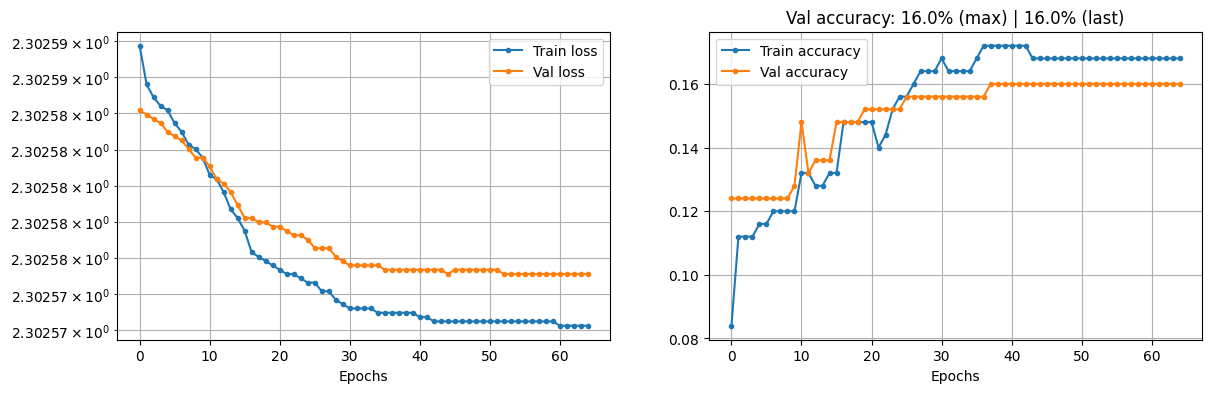

In [20]:
[h, m] = make_model(df_train_small, df_val, 
                    batch_size=25, data_augmentation_layer=None, 
                    image_net=False, img_size=(80, 80), epochs=250)
plots(h)

## 2.3 Data augmentation

Aplique diferentes tipos data augmentation nas imagens, retreine o modelo do item 1. e comente os resultados encontrados (ex: RandomFlip, RandomRotation, RandomContrast, etc)

In [15]:
from keras import layers

data_augmentation1 = keras.Sequential(
    [
        layers.RandomFlip(mode='horizontal'),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
    ],
    name='data_augmentation',
)

data_augmentation2 = keras.Sequential(
    [
        layers.RandomFlip(mode='horizontal'),
        layers.RandomRotation(factor=0.1),
    ],
    name='data_augmentation',
)

data_augmentation3 = keras.Sequential(
    [
        layers.RandomFlip(mode='horizontal'),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1)
    ],
    name='data_augmentation',
)

data_augmentation4 = keras.Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomRotation(factor=0.1)
    ],
    name='data_augmentation',
)

data_augmentation5 = keras.Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1)
    ],
    name='data_augmentation',
)

data_augmentation6 = keras.Sequential(
    [
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1)
    ],
    name='data_augmentation',
)

2025-10-24 02:48:24.547611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10305 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1
2025-10-24 02:48:24.548215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10295 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1


In [22]:
data_augmentation_list = [data_augmentation1, data_augmentation2, data_augmentation3, data_augmentation4, data_augmentation5, data_augmentation6]

history = []
val_acc = []
for data_augmentation in data_augmentation_list:
  [h, m] = make_model(df_train_small, df_val, 
                    batch_size=25, data_augmentation_layer=data_augmentation, 
                    image_net=True, img_size=(80, 80), epochs=25)
  
  history.append(h)
  val_acc.append(h.history['val_accuracy'][-1])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 80, 80, 3)         0         
 ial)                                                            
                                                                 
 lambda_12 (Lambda)          (None, 80, 80, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_6 (Dense)             (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25
10/10 [==============================] - 10s 142ms/step - loss

In [23]:
print(f'Acurácia de Validação para diferentes camadas de data augmentation:')
print(f'  Camada  | Acurácia ')
print(f'----------|----------')
for i in range(len(data_augmentation_list)):
  print(f'{str(i).center(10)}| {val_acc[i]:.4f} ')

Acurácia de Validação para diferentes camadas de data augmentation:
  Camada  | Acurácia 
----------|----------
    0     | 0.6160 
    1     | 0.6360 
    2     | 0.5880 
    3     | 0.6200 
    4     | 0.5920 
    5     | 0.6280 


## 2.4 Mudança de tamanho

a) Experimente diferentes tamanhos de imagem (até 225x225), meça a acurácia de validação e o tempo de treinamento para cada tamanho de imagem e organize-os em uma tabela ou curvas

In [24]:
history = []
val_acc = []
img_size_list = [(80, 80), (100, 100), (150, 150), (220, 220)]
for img_size in img_size_list:
  [h, m] = make_model(df_train_small, df_val, 
                    batch_size=25, data_augmentation_layer=data_augmentation1, 
                    image_net=True, img_size=img_size, epochs=25)

  history.append(h)
  val_acc.append(h.history['val_accuracy'][-1])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 80, 80, 3)         0         
 ial)                                                            
                                                                 
 lambda_18 (Lambda)          (None, 80, 80, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_12 (Dense)            (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25
10/10 [==============================] - 10s 136ms/step - los

2025-10-24 01:56:04.335290: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-24 01:56:04.348009: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-24 01:56:04.366135: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-24 01:56:04.383015: W external/local_tsl/tsl/framework/bfc_

10/10 [==============================] - 13s 206ms/step - loss: 2.3039 - accuracy: 0.1880 - val_loss: 2.1715 - val_accuracy: 0.2640 - lr: 1.0000e-05
Epoch 2/25
10/10 [==============================] - 1s 141ms/step - loss: 1.9144 - accuracy: 0.3720 - val_loss: 1.9202 - val_accuracy: 0.3760 - lr: 1.0000e-05
Epoch 3/25
10/10 [==============================] - 1s 143ms/step - loss: 1.6091 - accuracy: 0.5760 - val_loss: 1.6804 - val_accuracy: 0.4880 - lr: 1.0000e-05
Epoch 4/25
10/10 [==============================] - 1s 141ms/step - loss: 1.2942 - accuracy: 0.7080 - val_loss: 1.4337 - val_accuracy: 0.5800 - lr: 1.0000e-05
Epoch 5/25
10/10 [==============================] - 1s 140ms/step - loss: 1.0047 - accuracy: 0.8280 - val_loss: 1.1873 - val_accuracy: 0.6760 - lr: 1.0000e-05
Epoch 6/25
10/10 [==============================] - 1s 141ms/step - loss: 0.7208 - accuracy: 0.8720 - val_loss: 0.9695 - val_accuracy: 0.7440 - lr: 1.0000e-05
Epoch 7/25
10/10 [==============================] - 1s 1

2025-10-24 01:56:53.414638: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-24 01:56:53.429818: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-24 01:56:53.441592: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-24 01:56:53.469104: W external/local_tsl/tsl/framework/bfc_

10/10 [==============================] - 16s 347ms/step - loss: 2.2001 - accuracy: 0.2400 - val_loss: 2.0906 - val_accuracy: 0.3040 - lr: 1.0000e-05
Epoch 2/25
10/10 [==============================] - 3s 285ms/step - loss: 1.9077 - accuracy: 0.4320 - val_loss: 1.8819 - val_accuracy: 0.4680 - lr: 1.0000e-05
Epoch 3/25
10/10 [==============================] - 3s 285ms/step - loss: 1.6305 - accuracy: 0.6160 - val_loss: 1.6542 - val_accuracy: 0.6440 - lr: 1.0000e-05
Epoch 4/25
10/10 [==============================] - 3s 284ms/step - loss: 1.3458 - accuracy: 0.7560 - val_loss: 1.3921 - val_accuracy: 0.7200 - lr: 1.0000e-05
Epoch 5/25
10/10 [==============================] - 3s 284ms/step - loss: 1.0270 - accuracy: 0.8800 - val_loss: 1.1026 - val_accuracy: 0.7960 - lr: 1.0000e-05
Epoch 6/25
10/10 [==============================] - 3s 285ms/step - loss: 0.7038 - accuracy: 0.9280 - val_loss: 0.8240 - val_accuracy: 0.8560 - lr: 1.0000e-05
Epoch 7/25
10/10 [==============================] - 3s 2

In [25]:
print(f'Acurácia de Validação para diferentes tamanhos de imagem:')
print(f'  Tamanho | Acurácia ')
print(f'----------|----------')
for i, img_size in enumerate(img_size_list):
  print(f'{str(img_size).center(10)}| {val_acc[i]:.4f} ')

Acurácia de Validação para diferentes tamanhos de imagem:
  Tamanho | Acurácia 
----------|----------
 (80, 80) | 0.6520 
(100, 100)| 0.7600 
(150, 150)| 0.8640 
(220, 220)| 0.9000 


b) Escolha um tamanho de imagem para as próximas questões

Considerando a tabela acima, será utilizado o tamanho 220x220

## 2.5 Mudança de arquitetura

Troque a arquitetura escolhida do Keras Applications e compare com os resultados do Item 4.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 220, 220, 3)       0         
 ial)                                                            
                                                                 
 lambda_12 (Lambda)          (None, 220, 220, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_6 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 23501962 (89.65 MB)
Non-trainable params: 106240 (415.00 KB)
_________________________________________________________________
Epoch 1/25
10/10 [==============================] - 19s 302ms/step - loss

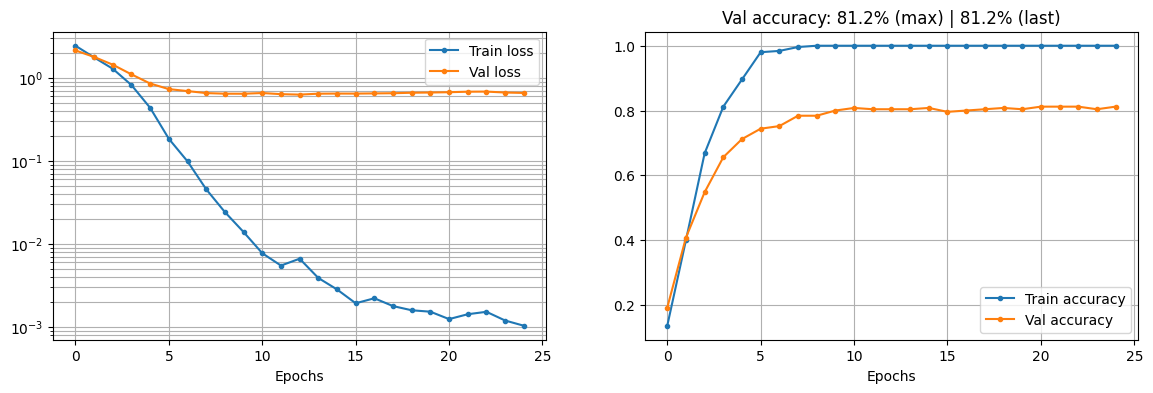

In [20]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

batch_size=25
data_augmentation_layer=data_augmentation1
img_size=(220, 220)
epochs=25

ds_train = create_dataset(df_train_small, img_size, batch_size)
ds_val = create_dataset(df_val, img_size, batch_size)


base_model = ResNet50()

input_shape = img_size + (3,)

base_model = ResNet50(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

keras.utils.set_random_seed(0)
model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        data_augmentation_layer,
        keras.layers.Lambda(preprocess_input),
        base_model,
        keras.layers.Dense(10, activation='softmax'),
    ]
)

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.00001))

model.summary()

callbacks = [EarlyStopping(patience=20), ReduceLROnPlateau(factor=0.2, patience=15, verbose=1)]

history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks, batch_size=batch_size)

plots(history)

## 2.6 Curva de treinamento



a) Selecione as primeiras n imagens de cada classe para gerar subconjuntos a partir do dataset de treinamento completo (df_train), por exemplo, n=5, 10, 15, 20, 25, 50, 75, 100

Para reduzir variações, tente garantir que cada conjunto esteja contido no próximo


In [27]:
n_values = [5, 10, 15, 20, 25, 50, 75, 100]
df_train_subsets = {}

for n in n_values:
    df_subset = df_train.groupby('target').head(n).reset_index(drop=True)
    df_train_subsets[n] = df_subset
    print(f'Subset with {n:3d} images per class: {len(df_subset):4d} total images')

Subset with   5 images per class:   50 total images
Subset with  10 images per class:  100 total images
Subset with  15 images per class:  150 total images
Subset with  20 images per class:  200 total images
Subset with  25 images per class:  250 total images
Subset with  50 images per class:  500 total images
Subset with  75 images per class:  750 total images
Subset with 100 images per class: 1000 total images


b) Treine um modelo para cada tamanho do dataset de treinamento e meça o desempenho de treinamento e de validação

In [28]:
history = []
val_acc = []

for idx, (n, df_subset) in enumerate(df_train_subsets.items()):
  [h, m] = make_model(df_subset, df_val, 
                    batch_size=25, data_augmentation_layer=data_augmentation1, 
                    image_net=True, img_size=(220, 220), epochs=25)

  history.append(h)
  val_acc.append(h.history['val_accuracy'][-1])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 lambda_23 (Lambda)          (None, 220, 220, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_17 (Dense)            (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25
2/2 [==============================] - 12s 1s/step - loss: 6.

c) Plote uma curva de treinamento com as acurácias em função do tamanho do dataset de treinamento 

Acurácia de Validação por Tamanho do Dataset de Treinamento:
Imagens por Classe | Acurácia 
-------------------|----------
         5         | 0.2560 
         10        | 0.2680 
         15        | 0.2840 
         20        | 0.3640 
         25        | 0.3360 
         50        | 0.4320 
         75        | 0.4400 
        100        | 0.5600 


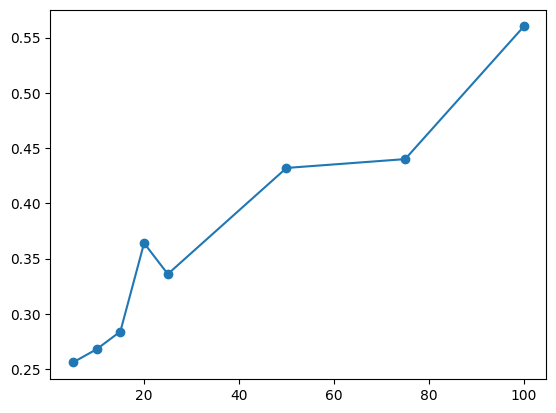

In [29]:
print(f'Acurácia de Validação por Tamanho do Dataset de Treinamento:')
print(f'Imagens por Classe | Acurácia ')
print(f'-------------------|----------')
for i, acc in enumerate(val_acc):
    print(f'{str(n_values[i]).center(19)}| {acc:.4f} ')

plt.plot(n_values, val_acc, 'o-')

d) Para o dataset de treinamento completo, retreine o modelo sem a utilização de data augmentation e compare os resultados

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 220, 220, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 220, 220, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20772914 (79.24 MB)
Non-trainable params: 109056 (426.00 KB)
_________________________________________________________________
Epoch 1/25


2025-10-24 02:49:03.984536: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2025-10-24 02:49:05.534341: I external/local_xla/xla/service/service.cc:168] XLA service 0x7c470cef0550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-24 02:49:05.534375: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-10-24 02:49:05.534383: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-10-24 02:49:05.540649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761274145.609627  467644 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - 29s 372ms/step - loss: 1.8272 - accuracy: 0.4830 - val_loss: 1.3457 - val_accuracy: 0.7560 - lr: 1.0000e-05
Epoch 2/25
40/40 [==============================] - 9s 225ms/step - loss: 0.7041 - accuracy: 0.8970 - val_loss: 0.4417 - val_accuracy: 0.9120 - lr: 1.0000e-05
Epoch 3/25
40/40 [==============================] - 9s 226ms/step - loss: 0.1729 - accuracy: 0.9640 - val_loss: 0.2716 - val_accuracy: 0.9240 - lr: 1.0000e-05
Epoch 4/25
40/40 [==============================] - 9s 227ms/step - loss: 0.0612 - accuracy: 0.9930 - val_loss: 0.2432 - val_accuracy: 0.9320 - lr: 1.0000e-05
Epoch 5/25
40/40 [==============================] - 9s 226ms/step - loss: 0.0285 - accuracy: 0.9980 - val_loss: 0.2315 - val_accuracy: 0.9360 - lr: 1.0000e-05
Epoch 6/25
40/40 [==============================] - 9s 227ms/step - loss: 0.0145 - accuracy: 0.9990 - val_loss: 0.2275 - val_accuracy: 0.9400 - lr: 1.0000e-05
Epoch 7/25
40/40 [==============================] - 9s 2

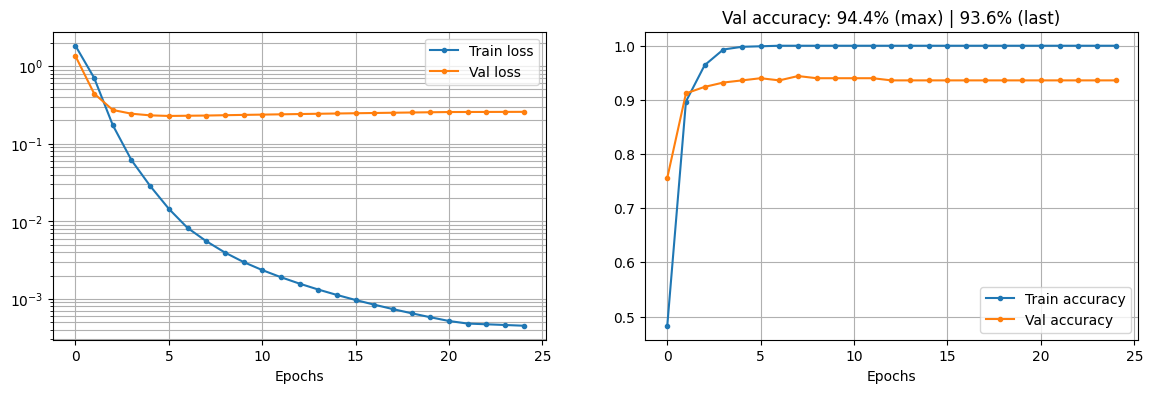

In [16]:
[h, m] = make_model(df_train, df_val, 
                    batch_size=25, data_augmentation_layer=None, 
                    image_net=True, img_size=(220, 220), epochs=25)
plots(h)

e) Comente os resultados observados

**Comentários:** Até esta etapa do trabalho foi possível observar que:

- menores *batch_size* apresentam melhores acuracias; 
- que quando importado o modelo sem os pesos da Imagenet ele tem um desempenho muito mais baixo, ou seja, a inicialização dos pesos permite com que o modelo responda muito melhor; 
- foi possível escolher um conjunto de data augmentation que melhora o desempenho do algoritmo; 
- que enquanto maior a imagem, melhor o desempenho do modelo; 
- que a ResNet50 se mostrou muito interessante com acuracia um pouco abaixo da Xception, para as mesmas condições definidas com base na Xception; 
- que enquanto mais amostras para treinamento, melhor fica o resultado, ao menos quando avaliado até 100 amostras; 

# 3. Resultados no conjunto de teste

Para essa seção utilize o modelo treinado na 2.6.d para mostrar as seguinte informações a no conjunto de teste

In [17]:
import itertools

ds_test = create_dataset(df_test, img_size=(220,220), batch_size=250)
classe_pred = m.predict(ds_test, verbose=1)
y_pred = np.array(sorted(df_train['target'].unique()))[np.argmax(classe_pred, axis=1)]

y_true = [np.array(sorted(df['target'].unique()))[y.numpy()] for x, y in ds_test]
y_true = list(itertools.chain.from_iterable(y_true))

X_list = []
Y_list = []

for x_batch, y_batch in ds_test:
    X_list.append(x_batch.numpy())
    Y_list.append(np.array(sorted(df['target'].unique()))[y_batch.numpy()])

X_completo = np.concatenate(X_list, axis=0)
Y_completo = np.concatenate(Y_list, axis=0)


2025-10-24 02:53:46.215149: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-24 02:53:46.494663: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 10s 10s/step


## 3.1 Acurácia encontrada

In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f'Acurácia no conjunto de teste: {100*accuracy:.4f}%')

Acurácia no conjunto de teste: 94.8000%


In [19]:
ds_test = create_dataset(df_test, img_size=(220,220), batch_size=25)
metricas = m.evaluate(ds_test, batch_size=25, verbose=1, return_dict=True)
print(f'Acurácia no conjunto de teste: {100*metricas["accuracy"]:.4f}%')


10/10 [==============================] - 1s 60ms/step - loss: 0.1540 - accuracy: 0.9480
Acurácia no conjunto de teste: 94.8000%


## 3.2 Matriz de confusão

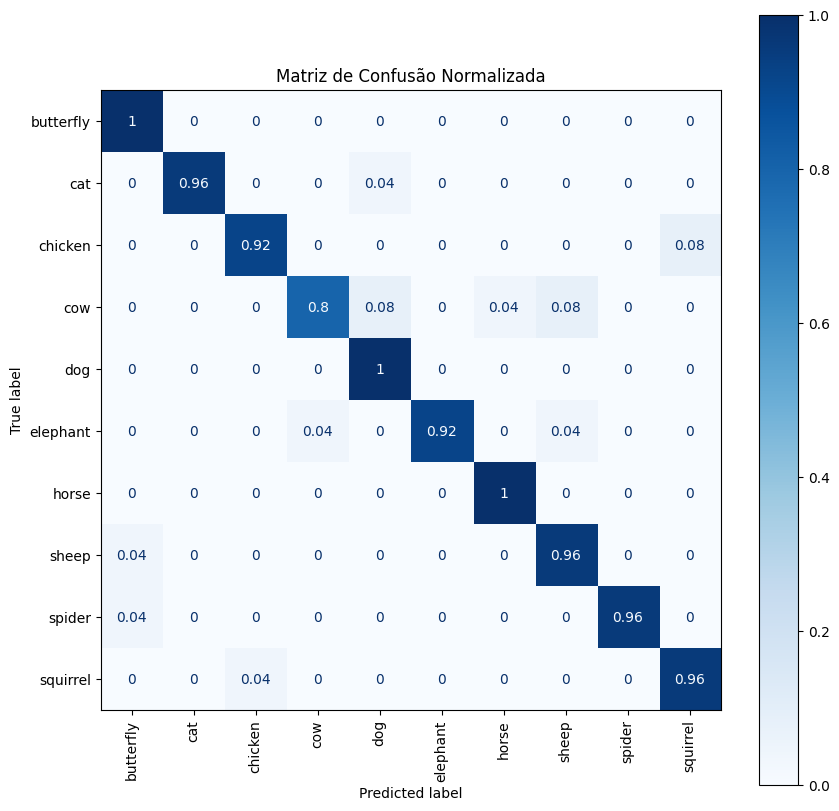

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(df['target'].unique()))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
plt.title('Matriz de Confusão Normalizada')
plt.show()

# 3.3 Erros

Mostre ao menos 15 imagens onde o modelo cometeu erros de classificação, além dos labels reais e previstos

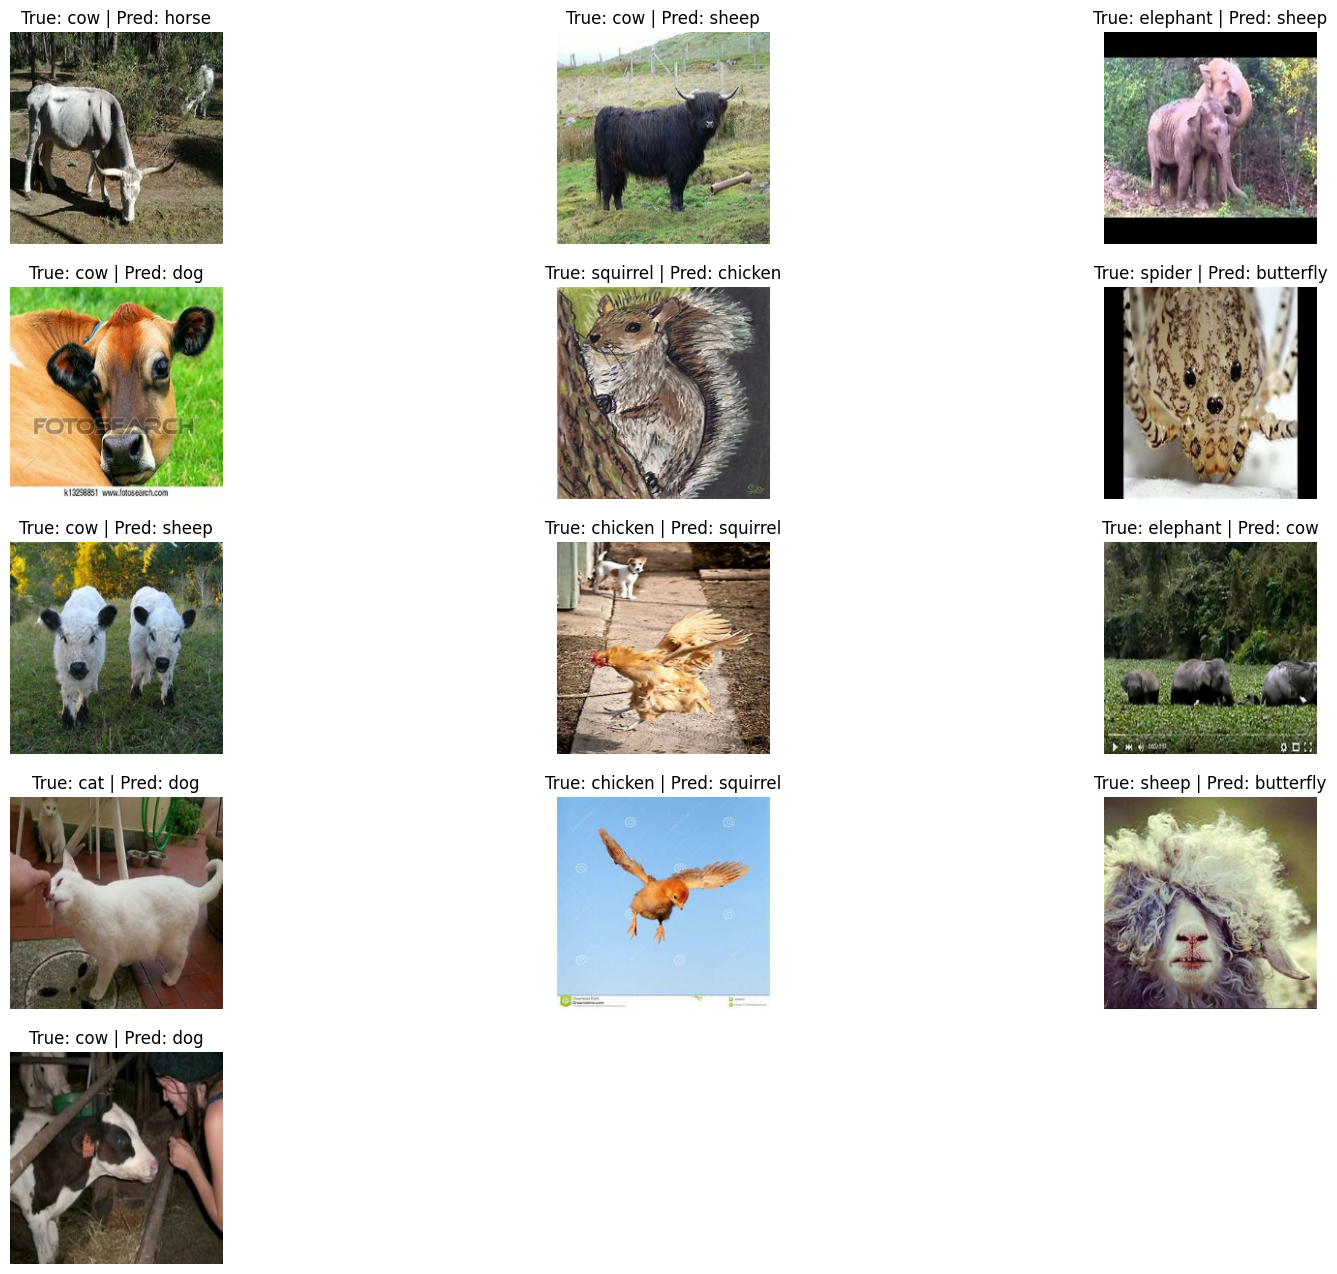

In [22]:
plt.figure(figsize=(20, 16))
c = 1
for idx, img in enumerate(X_completo):
    if y_pred[idx] != y_true[idx]:
        plt.subplot(5, 3, c)
        plt.imshow(np.clip(img / 255.0, 0.0, 1.0))
        plt.title(f'True: {y_true[idx]} | Pred: {y_pred[idx]}')
        plt.axis('off')
        c += 1

# 4. Domain Shift

Nessa etapa a ideia é somente observar os resultados nesse novo conjunto a partir dos treinamentos realizados anteriormente. Desta forma, deve-se somente configurar esse novo conjunto de dados e avaliar as predições no modelo nele. Não treinar o modelo novamente. 

## 4.1 Conjunto de dados

Utilize como base o código disponível no notebook auxiliar para gerar o conjunto de dados a ser utilizado nesta etapa (utilize 100 imagens por classe, conforme o notebook de exemplo)

Lembre de ajustar o tamanho da imagem utilizado pelo seu modelo


In [23]:
def prepare_keras_dataset(keras_dataset, label_dict):
  (x_train, y_train), (x_test, y_test) = keras_dataset.load_data()
  x = np.concatenate((x_train, x_test))
  y = np.concatenate((y_train, y_test)).reshape(-1)
  idx = np.isin(y, list(label_dict.keys()))
  x = x[idx]
  y = y[idx]
  labels = pd.Series(y).replace(label_dict).to_numpy()
  return x, labels

In [24]:
def reduce_dataset(df, samples_per_class, random_state=0):
  df_new = pd.DataFrame()
  classes = sorted(df['target'].unique())
  for c in classes:
    temp = df[df['target'] == c].sample(samples_per_class, random_state=random_state)
    df_new = pd.concat([df_new, temp], ignore_index=True)
  return df_new

In [25]:
import keras

cifar10_dict = {3: 'cat', 5: 'dog', 7: 'horse'}
(x_cifar10, labels_cifar10) = prepare_keras_dataset(keras.datasets.cifar10, cifar10_dict)

cifar100_dict = {14: 'butterfly', 31: 'elephant', 79: 'spider', 80: 'squirrel'}
(x_cifar100, labels_cifar100) = prepare_keras_dataset(keras.datasets.cifar100, cifar100_dict)

x = np.concatenate((x_cifar10, x_cifar100))
labels = np.concatenate((labels_cifar10, labels_cifar100))

print(x.shape, labels.shape)
pd.Series(labels).value_counts()

(20400, 32, 32, 3) (20400,)


horse        6000
cat          6000
dog          6000
elephant      600
squirrel      600
butterfly     600
spider        600
dtype: int64

In [26]:
samples_per_class = 100
df = pd.DataFrame({'target': labels}).reset_index()
df = reduce_dataset(df, samples_per_class)
x = x[df['index']]
labels = df['target'].to_numpy()
y = pd.Series(labels).map(sorted(df['target'].unique()).index).to_numpy()

print(x.shape, y.shape, labels.shape)
pd.Series(labels).value_counts()

(700, 32, 32, 3) (700,) (700,)


butterfly    100
cat          100
dog          100
elephant     100
horse        100
spider       100
squirrel     100
dtype: int64

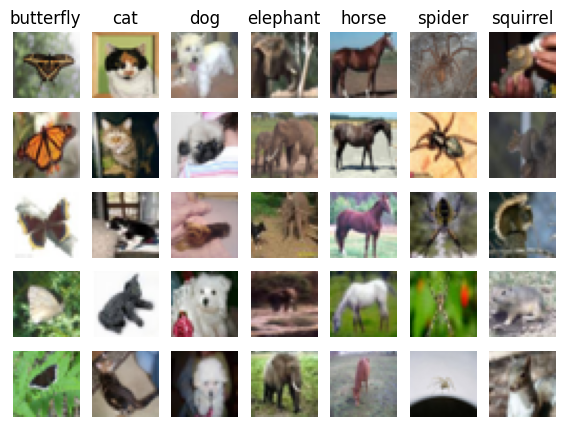

In [27]:
# Show examples
plt.figure(figsize=(7, 5))
for i in range(5):
  for j, label in enumerate(np.unique(labels)):
    plt.subplot(5, 7, 7*i+j+1)
    img = x[labels == label][i]
    plt.imshow(img)
    if i == 0:
      plt.title(label)
    plt.axis('off')

In [31]:
x_resized = np.array([tf.image.resize(img, (220, 220)).numpy() for img in x])
x_resized.shape

(700, 220, 220, 3)

## 4.2 Faça as previsões nesse conjunto

In [32]:
y_pred = np.argmax(m.predict(x_resized), axis=1)


22/22 [==============================] - 4s 120ms/step


## 4.3 Repita as análises da seção 3

### 4.3.1 Acurácia encontrada

In [33]:
print(f'Accuracy: {np.mean(y_pred == y):.1%}')

Accuracy: 16.0%


### 4.3.2 Matriz de confusão

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (7).

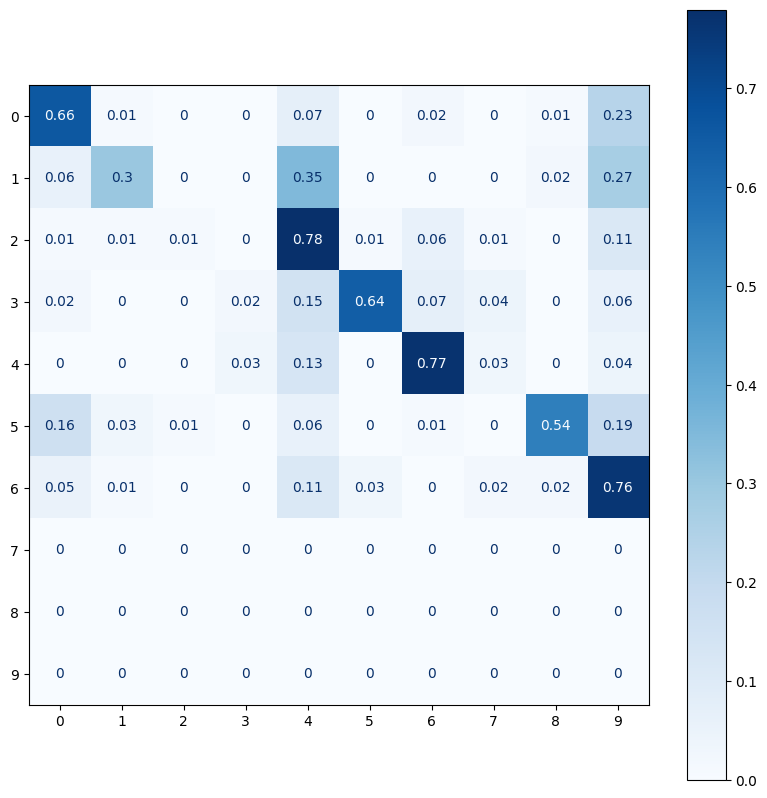

In [37]:
cm = confusion_matrix(y, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(df['target'].unique()))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
plt.title('Matriz de Confusão Normalizada')
plt.show()

### 4.3.3 Erros

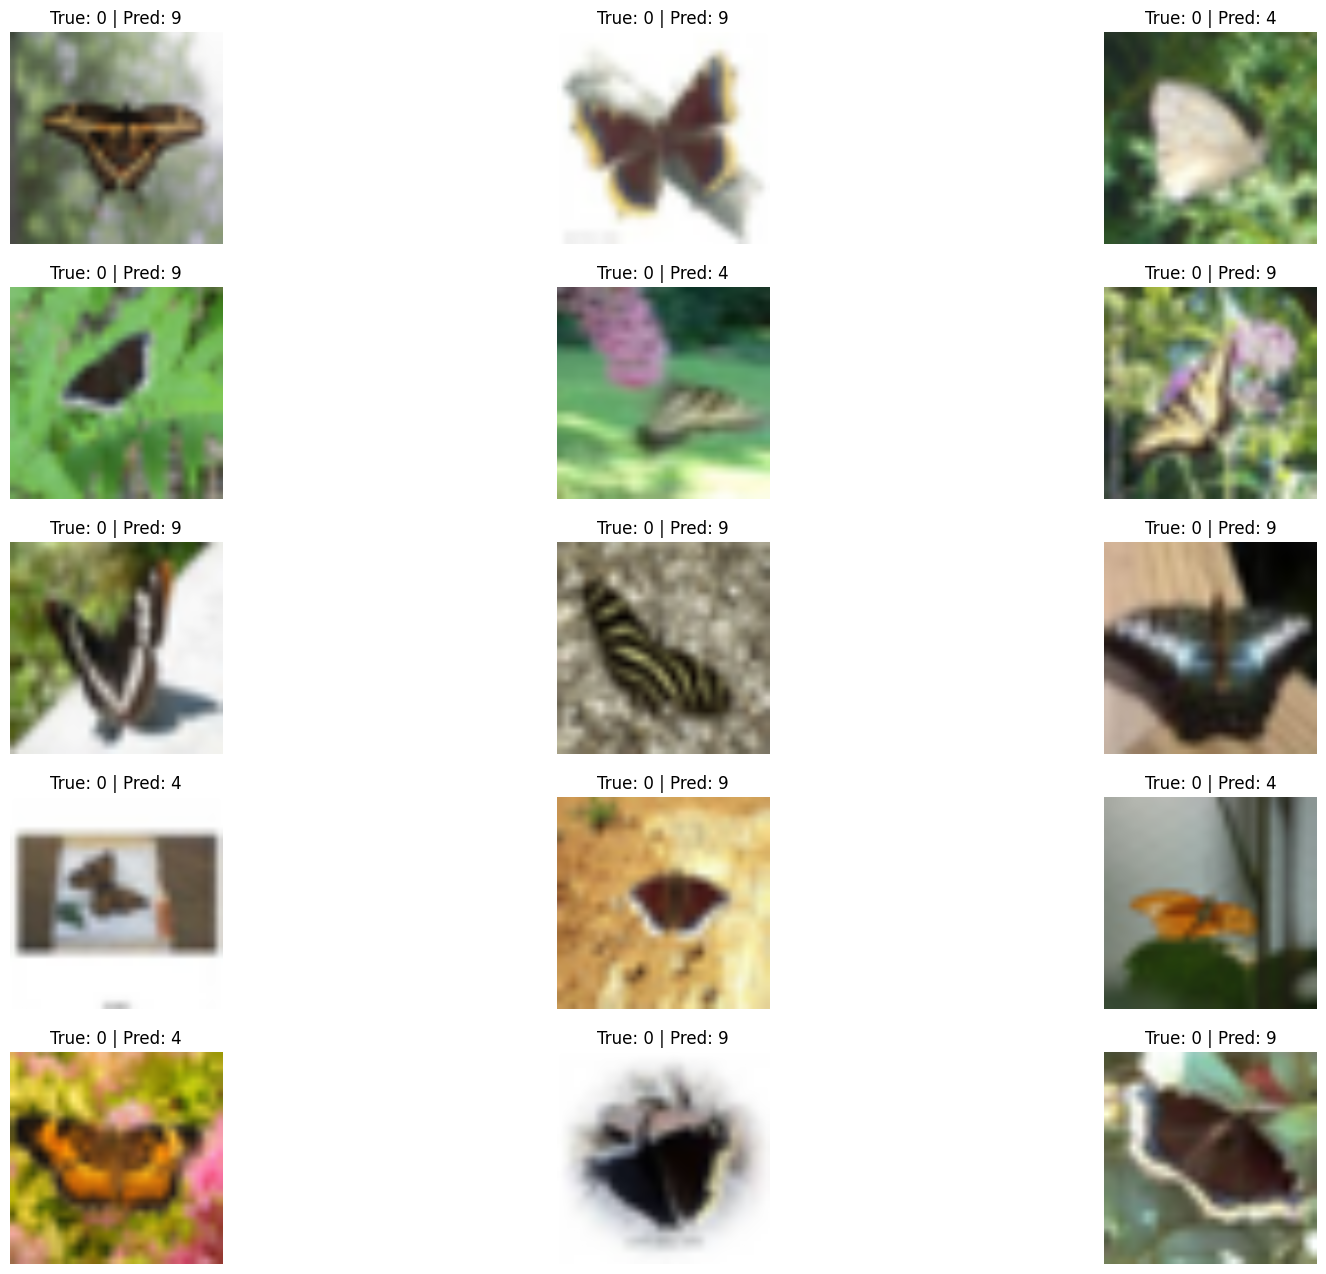

In [39]:
plt.figure(figsize=(20, 16))
c = 1
for idx, img in enumerate(x_resized):
    if (y_pred[idx] != y[idx]) and (c <= 15):
        plt.subplot(5, 3, c)
        plt.imshow(np.clip(img / 255.0, 0.0, 1.0))
        plt.title(f'True: {y[idx]} | Pred: {y_pred[idx]}')
        plt.axis('off')
        c += 1

## 4.4 Hipoteses

Que hipóteses você imagina que poderiam explicar o desempenho obtido neste dataset, em comparação com o dataset original?

**Resposta:** A principal hipotese é de que como as figuras deste novo dataset são significativamente menores (32x32) o modelo terá um desempenho menor, mesmo havendo o resize (que apenas aumenta a imagem, mas sem resolução). Isso também pode ser inferido pelo teste feito em 2.4 onde observamos que o aumento da imagem melhora o desempenho.

# 5. Comentários e discussão

Discorra sobre o aprendizado e dificuldades com o trabalho e, se quiser, comentários ou sugestões para as atividades

**Comentários:** A atividade foi muito interessante, permitindo compreender conceitos de treinamento de modelos para imagens e de reutilização de arquitetura. Houveram algumas dificuldades que foram superadas com pesquisa ou ajuda do monitor.

As principais dificuldade estavam relacionadas a detalhes da biblioteca ou questões de programação.

Também foi muito interessante ver o modelo funcionando com dados de outro conjunto de dados, apesar de sem significativamente menores, causando maior dificuldade para predição.
